In [2]:
using PyPlot
using LsqFit
include("../mc_julia.jl")

drop_the_mic (generic function with 1 method)

In [1]:
include("../compute_ttv.jl")
importall TTVFaster

### 0. Read and plot TTV data 

In [3]:
dat1 = readdlm("../ttv_planet1.txt")
t1 = dat1[:,1]
dat2 = readdlm("../ttv_planet2.txt")
t2 = dat2[:,1];

In [4]:
p_guesser(time::Array{Float64}) = mean(diff(time))
per_guess1 = p_guesser(t1)
per_guess2 = p_guesser(t2) ;

In [5]:
println(per_guess1,'\n',per_guess2)
# 5. venus and earth!

224.70076641863517
365.25630708152175


In [6]:
reg_transits(t0::Float64,period::Float64,n_trans::Int64) = [t0+period*(i-1) for i=1:n_trans]
#returns regular transit times ;

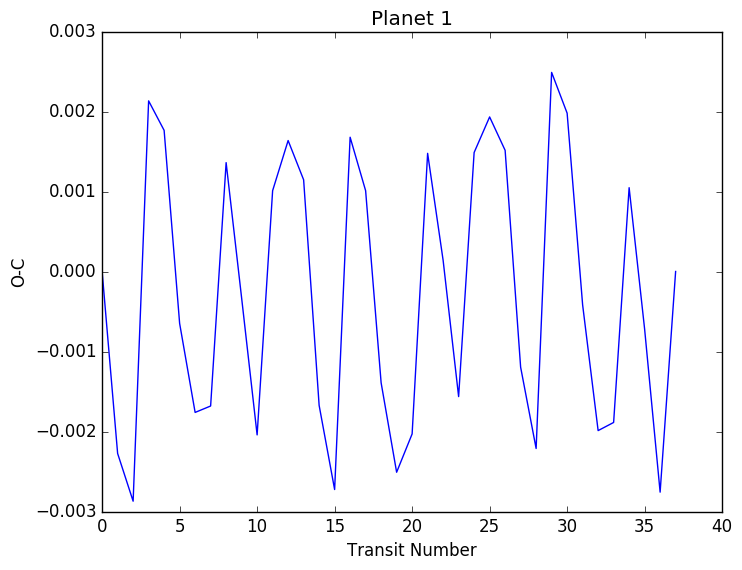

In [7]:
plot(t1-reg_transits(t1[1],per_guess1,length(t1)))
xlabel("Transit Number")
ylabel("O-C")
title("Planet 1") ;

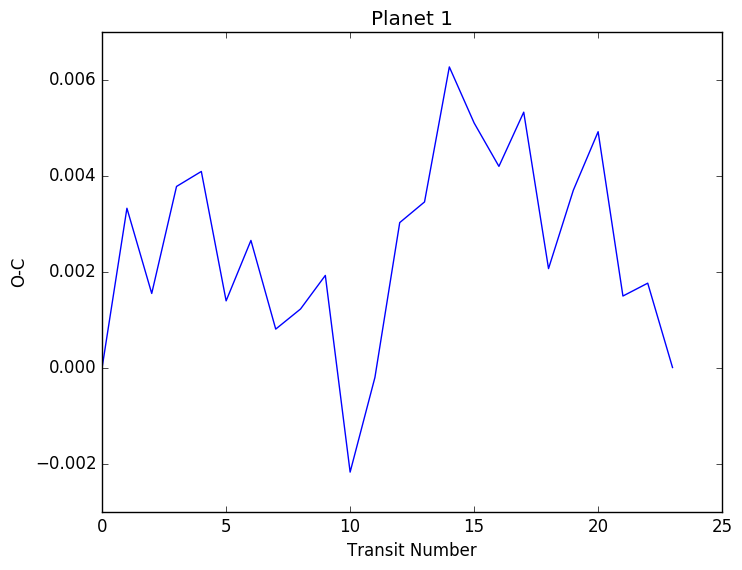

In [8]:
plot(t2-reg_transits(t2[1],per_guess2,length(t2)))
xlabel("Transit Number")
ylabel("O-C")
title("Planet 1") ;

### 1. Create a wrapper for compute_ttv.jl which calls N(N-1) pairs of planets to compute the TTV of each planet due to all of the others.

In [9]:
function make_plane(mass_ratio::Float64,period::Float64,t0::Float64,ecosw::Float64,esinw::Float64)
    plane = Planet_plane_hk(mass_ratio, period, t0, ecosw, esinw)
    return plane
end

make_plane (generic function with 1 method)

In [54]:
function compute_ttv_pairs(n_p::Int64,n_trans_arr::Array{Int64},jmax::Int64,planets::Array{TTVFaster.Planet_plane_hk{Float64},1})
    ttvs = Array{Array{Float64}}(n_p)
    times = Array{Array{Float64}}(n_p)
    for i=1:n_p
        ttvs[i] = zeros(n_trans_arr[i])
        times[i] = reg_transits(planets[i].trans0,planets[i].period,n_trans_arr[i])
    end
    for i=1:n_p-1 #for each planet
        for j=i:n_p #go to each other planet
            if i!= j #make sure its not this planet
                time1 = times[i]
                time2 = times[j]
                ttvs1 = zeros(length(time1))
                ttvs2 = zeros(length(time2))
                compute_ttv!(jmax,planets[i],planets[j],time1,time2,ttvs1,ttvs2) #compute ttvs, add to array
                ttvs[i] .+= ttvs1 #add on to the TTVs
                ttvs[j] .+= ttvs2
            end
        end
    end
    return (ttvs,times.+ttvs)
end

compute_ttv_pairs (generic function with 1 method)

In [47]:
#Testing model works
plane1 = make_plane(.01,per_guess1,1.,0.1,0.1)
plane2 = make_plane(.01,per_guess2,1.,0.1,0.1)
plane_test = make_plane(0.1,100.0,1.,0.1,0.1)

5-element Array{Symbol,1}:
 :mass_ratio
 :period    
 :trans0    
 :ecosw     
 :esinw     

In [62]:
times = Array{Float64}[t1,t2]
planes = [plane1,plane2,plane_test]
ttvs,times = compute_ttv_pairs(2,[length(t1),length(t2)],10,planes) 
#NOTE: When inserting a 3rd planet, it needs to be an outer planet! ;

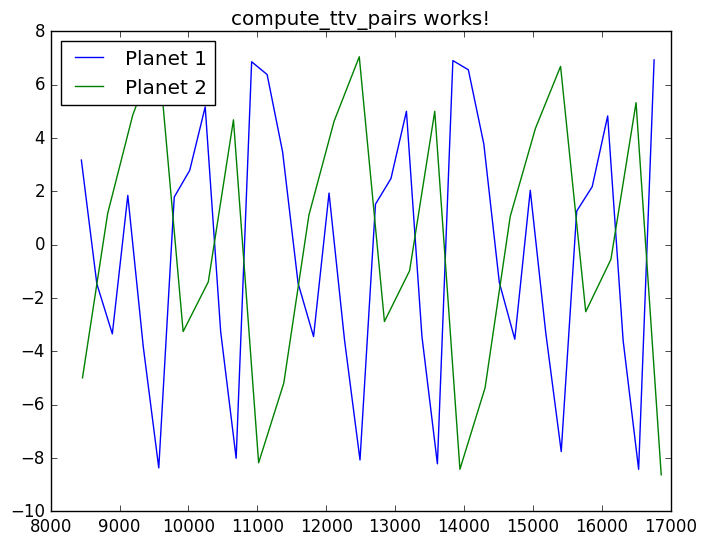

PyObject <matplotlib.text.Text object at 0x3251d5290>

In [63]:
plot(t1,ttvs[1],label="Planet 1")
plot(t2,ttvs[2],label="Planet 2")
legend(loc=0)
title("compute_ttv_pairs works!")

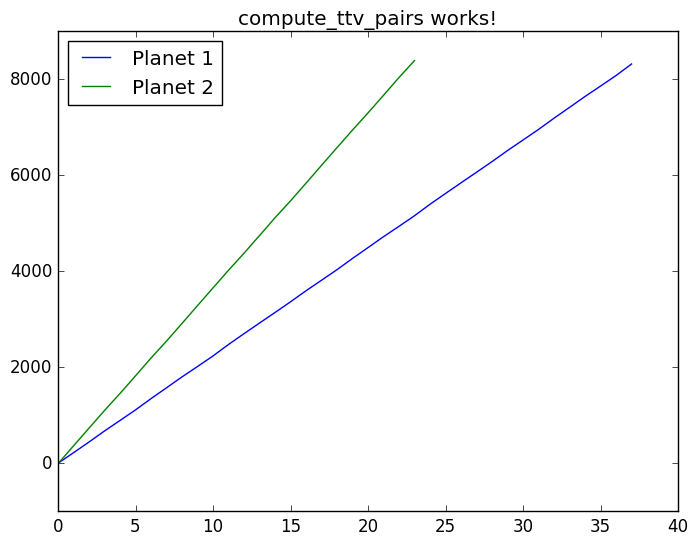

PyObject <matplotlib.text.Text object at 0x3255da890>

In [64]:
plot(times[1],label="Planet 1")
plot(times[2],label="Planet 2")
legend(loc=0)
title("compute_ttv_pairs works!")

### 2. Carry out an initial fit to the transit times of the two planets.

In [80]:
function ttv_model(times::Array{Array{Float64}},p::Array{Float64})
    for (ecos,esin) in zip(p[4:5:end],p[5:5:end])
        if (abs(ecos)>=1)||(abs(esin)>=1)
            return Inf
        end
    end
    n_p = length(times)
    n_trans_arr = Int64[]
    for i=1:n_p
        push!(n_trans_arr,length(times[i]))
    end
    planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p]
    ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)
    lin_out = Float64[]
    for i=1:n_p
        append!(lin_out,trans_times[i])
    end
    return lin_out #regular transits plus the TTVS
end

ttv_model (generic function with 1 method)

In [79]:
abs(-2)

2

In [81]:
function fit_ttvs(n_p::Int64,times::Array{Array{Float64}})
        
    #1D array of times to make fitting easier
    lintimes = Float64[]
    for i=1:n_p
        append!(lintimes,times[i])
    end
    
    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision
    
    p0 = zeros(5*n_p)
    #initialize params
    #p[1]-p[5] = mass_ratio, period, t0, ecosw, esinw, first planet
    #p[6] - p[10] = same params but second planet
    for i=1:n_p
        p0[1+5*(i-1)] = 2.0e-6
        p0[2+5*(i-1)] = p_guesser(times[i])
        p0[3+5*(i-1)] = times[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
        
    fit = curve_fit(ttv_model,times,lintimes,weights,p0)
    
end

fit_ttvs (generic function with 1 method)

In [82]:
result = fit_ttvs(2,times) ;

LoadError: LoadError: AssertionError: alpha < 1
while loading In[82], in expression starting on line 1

In [76]:
parnames = ["M_1","P_1","t0_1","ecosw_1","esinw_1","M_2","P_2","t0_2","ecosw_2","esinw_2"]
for (nam,par) in zip(parnames,result.param)
    println("$nam = $par")
end

M_1 = 5.336355874389147e-5
P_1 = 224.71669826576812
t0_1 = 0.72190571168963
ecosw_1 = 28.143994857976693
esinw_1 = -1.6877239963054447
M_2 = 0.00011249479487784906
P_2 = 365.2375491833578
t0_2 = 1.305382145664877
ecosw_2 = 20.762236171261684
esinw_2 = 0.016019057419633418


### 3. Add in a third (non-transiting) planet to your model.  Make a grid in period, and optimize the fit over periods from 500-10,000 days & over ~10 phases for each period.  Plot the maximum likelihood versus period. Note 3: you’ll need to create a wrapper for curve_fit which allows the 3rd period to be fixed.

### Lets edit our model such that we can account for asking for extra planets

In [72]:
#now n_p is one larger than the number of transiting planets we have. Lets fit them.

#THIS IS COMPLETELY BROKEN: NEED TO THINK OF A MUCH BETTER WAY TO DO IT
function fit_ttv_nontransit(n_p::Int64,jmax::Int64,times::Array{Array{Float64}})
    
    n_p_t = length(times) #number of transiting planets
    println(n_p_t)
    
    #add dummy array to times for non-transiting planet
    append!(times,Array{Float64}[[0.0]])
    
    #1D array of times to make fitting easier
    lintimes = Float64[]
    for i=1:n_p
        append!(lintimes,times[i])
    end
    
    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision
    
    #initialize params
    p0 = zeros(5*n_p_t)
    for i=1:n_p_t
        p0[1+5*(i-1)] = 0.01
        p0[2+5*(i-1)] = p_guesser(times[i])
        p0[3+5*(i-1)] = times[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
     #last three*non_transiting_planets parameters are planet mass and eccentricity vector components. We'll grid over period and t0
    push!(p0,0.01)
    push!(p0,0.1)
    push!(p0,0.1)
    
    
    P_grid = logspace(log10(500),4)
    phase_grid = collect(linspace(0.0,0.9,10))
    
    chi_best = 10000000.0
    P_best = 0.0
    t0_best = 0.0
    par_best = Float64[]
    
    for P in P_grid
        
        #println(P)
        
        for phase in phase_grid
            
            #println(phase)
            
            t0 = phase*P
            
            function ttv_model(times::Array{Array{Float64}},p::Array{Float64})
                for i=1:n_p_t
                    println(p[2+5*(i-1)])
                    if p[2+5*(i-1)] >= P
                        return Inf
                    end
                end
                planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p_t]
                push!(planes,make_plane(p[1+5*n_p_t],P,t0,p[2+5*n_p_t],p[3+5*n_p_t]))
                ttvs = compute_ttv_pairs(n_p,jmax,planes,times) 
                reg_trans = Array{Float64}[reg_transits(p[3+5*(i-1)],p[2+5*(i-1)],length(times[i])) for i=1:n_p_t] #regular transits
                returned = Float64[]
                for i=1:n_p_t #no transits for the other planets
                    append!(returned,reg_trans[i].+ttvs[i])
                end
                return returned #regular transits plus the TTVS  
            end
            fit = curve_fit(ttv_model,times,lintimes,weights,p0) #fit, pull out parameters and chi2, if its the best, set P_best/best fit parameters equal to it
            chi2 = sum(fit.resid.^2*weights)
            if chi2 < chi_best
                chi_best = chi2
                P_best = P
                t0_best = t0
                par_best = fit.param
            end
        end
    end
    
    println(par_best,P_best,t0_best)
    
end

fit_ttv_nontransit (generic function with 1 method)

In [76]:
fit_ttv_nontransit(3,10,times)

2


LoadError: LoadError: DimensionMismatch("dimensions must match")
while loading In[76], in expression starting on line 1

224.70076641863517
365.25630708152175


In [19]:
splice!(foo,3,[20,foo[3]])

LoadError: LoadError: UndefVarError: foo not defined
while loading In[19], in expression starting on line 1

In [20]:
any(foo) > 0

99999999999994
0.0


LoadError: LoadError: UndefVarError: foo not defined
while loading In[20], in expression starting on line 1

In [21]:
logspace(log10(500),4)

50-element Array{Float64,1}:
   500.0  
   531.522
   565.032
   600.655
   638.523
   678.779
   721.572
   767.064
   815.423
   866.832
   921.481
   979.576
  1041.33 
     ⋮    
  5104.25 
  5426.05 
  5768.13 
  6131.79 
  6518.36 
  6929.31 
  7366.17 
  7830.57 
  8324.25 
  8849.05 
  9406.94 
 10000.0  